In [1]:
from essential_generators import DocumentGenerator
import sqlalchemy as sa
from sqlalchemy.sql import text
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import Session
import uuid
import random
import time
import pandas as pd
from multiprocessing import Pool
import itertools
from helper import executeScript, addRecords, timeInstance

In [2]:
# User customizable stuff
server = "mssql.ad.tdt"
database = "sqlHeapTest"
numRecords = 400000
results = []

# Setup database for testing
Connect to the base, and run the setupDB.sql contents

In [4]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_91241/3657996963.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})


In [5]:
executeScript(engine, "setupDB.sql")

# Setup Fixture Data
Using the newly created setup, connect and insert some test records

In [6]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")
conn = engine.connect()
conn

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_91241/2762592990.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")


In [7]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 400000


# Test 1
Setup a clustered index, timing how long it takes on one column

In [8]:
t = timeInstance(lambda: executeScript(engine, "test1.sql"))
results.append({
    "Test": "Test 1",
    "Description": "Create clustered Index, one column",
    "Time (s)": t
})

Completed in 4.1575 seconds


# Test 2
Remove the clustered index, timing how long it takes

In [9]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 2",
    "Description": "Drop single-column Clustered Index",
    "Time (s)": t
})

Completed in 0.0531 seconds


# Test 3
Insert another bunch of records and re-add the clustered index

In [10]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 400000


In [11]:
t = timeInstance(lambda: executeScript(engine, "test1.sql"))
results.append({
    "Test": "Test 3",
    "Description": "Create clustered Index, one column, extra records",
    "Time (s)": t
})

Completed in 6.9913 seconds


# Test 4
Drop the clustered index, again timing

In [12]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 4",
    "Description": "Drop single-column Clustered Index, extra records",
    "Time (s)": t
})

Completed in 0.0681 seconds


# Second Test!  With 2 columns in index

# Prep Database

In [13]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})
executeScript(engine, "setupDB.sql")

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_91241/2932847717.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})


In [14]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")
conn = engine.connect()
conn

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_91241/2762592990.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")


In [15]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 400000


# Test 5
Setup a clustered index, two columns, seeing how long it takes

In [16]:
t = timeInstance(lambda: executeScript(engine, "test3.sql"))
results.append({
    "Test": "Test 5",
    "Description": "Create clustered Index, two columns",
    "Time (s)": t
})

Completed in 5.9317 seconds


# Test 6
Remove the clustered index, timing how long it takes

In [17]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 6",
    "Description": "Drop dual-column Clustered Index",
    "Time (s)": t
})

Completed in 0.0436 seconds


# Test 7
Insert another bunch of records and re-add the clustered index

In [18]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 400000


In [19]:
t = timeInstance(lambda: executeScript(engine, "test3.sql"))
results.append({
    "Test": "Test 7",
    "Description": "Create clustered Index, 2 columns, extra records",
    "Time (s)": t
})

Completed in 24.8392 seconds


# Test 8
Drop the clustered Index, again timing

In [20]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 8",
    "Description": "Drop dual-column Clustered Index, extra records",
    "Time (s)": t
})

Completed in 0.2225 seconds


# Plot Results

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
pdResults = pd.DataFrame.from_dict(results)
pdResults

,Test,Description,Time (s)
0,Test 1,"Create clustered Index, one column",4.1575
1,Test 2,Drop single-column Clustered Index,0.0531
2,Test 3,"Create clustered Index, one column, extra records",6.9913
3,Test 4,"Drop single-column Clustered Index, extra records",0.0681
4,Test 5,"Create clustered Index, two columns",5.9317
5,Test 6,Drop dual-column Clustered Index,0.0436
6,Test 7,"Create clustered Index, 2 columns, extra records",24.8392
7,Test 8,"Drop dual-column Clustered Index, extra records",0.2225


In [23]:
pdResults["Time (s)"] = pdResults["Time (s)"].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Test         8 non-null      object 
 1   Description  8 non-null      object 
 2   Time (s)     8 non-null      float64
 3   Time         8 non-null      float64
dtypes: float64(2), object(2)
memory usage: 384.0+ bytes


<AxesSubplot:xlabel='Test', ylabel='Time (s)'>

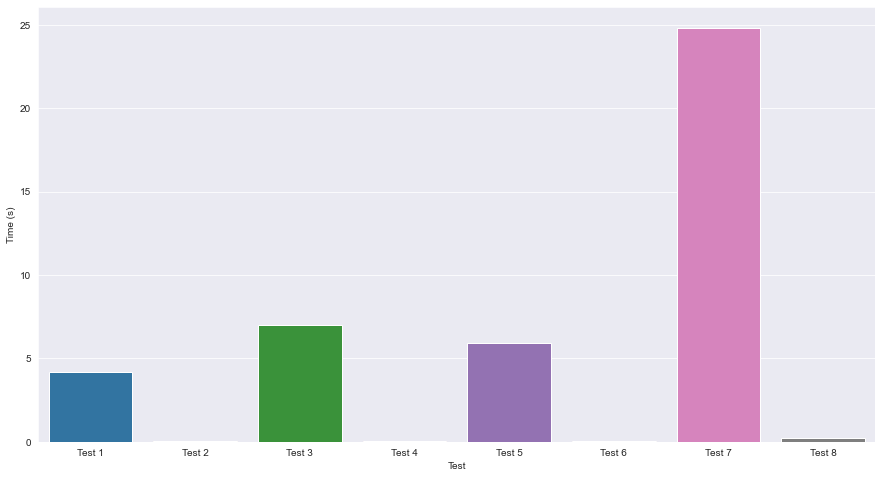

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(data=pdResults, x="Test", y="Time (s)")